In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from load_compas_data import *
%load_ext autoreload
%autoreload 2


import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression


# Societal Impact (Fairness) - Tutorial - 24.06.2021
## Overview

Hello! This is a practical tutorial. In this notebook, we are going to explore machine learning for societal impact hands-on.  We specifically conentrate on fairness in machine learning. We have left a few `#TODO` where implementation is missing. Take a look and try to implement it yourself! We will illustrate the implementation at the tutorial on Thursday. See you there!

The main goals of this notebook are:

- Learn different techniques on to evaluate fairness
- Explore how different fairness constraints affect different classifiers affect decision boundaries
- Explore the accuracy-fairness trade-off

This notebook has taken from / was inspired in parts by code available from the probabilistic learning group [here](https://github.com/probabilistic-learning/LvivSummerSchool19/tree/master/Code) of Prof. Isabel Valera.

## Installation and Download
For this notebook, we are using two new packages. If you have not yet installed them, you can do it e.g. via conda `conda install -c pytorch pytorch` and `conda install -c conda-forge texttable`.

In [2]:
import torch
import texttable as tt

For this notebook, we will also need the python file `load_compas_data.py`, which we have provided. Please download it and place it in the same folder as this notebook. 

## Datasets
We consider a synthetic biased dataset dataset with a multivariate normal distribution. It has two nonsensitive attributes and one sensitive attribute. The dataset and its generation function is taken from  Muhammad Bilal Zafar et al. [here](https://github.com/mbilalzafar/fair-classification). Green color denotes the positive class (e.g. creditworthy), red denotes negative (e.g. not credit worthy). Circles represent the non-protected group (e.g. males) while crosses represent the protected group (e.g. females). 
- What do you observe with respect to the correlation between class labels (green and red) and the sensitive feature values (protected and non-protected)? 

In [3]:
def generate_synthetic_data(n_samples, plot_data=False):

    """
        From: https://github.com/mbilalzafar/fair-classification
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) 
        and 1.0 means it's in non-protected group (e.g., male).
    """

    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        num_to_draw = 200 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
        plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
        plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
        plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")

        
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.legend(loc=2, fontsize=15)
        plt.xlim((-15,10))
        plt.ylim((-10,15))
        plt.show()

    #x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    X = np.concatenate((X,x_control.reshape(-1,1)), axis=1)
    data = np.concatenate((X,y.reshape(-1,1)),axis = 1)
    return pd.DataFrame(data=data, columns = ["x1","x2","sensitive","y"]), X, y

def plot_data(X,y,X_sens,axes=None):
    if axes is None:
        axes = plt.gca()
    num_to_draw = 200 # we will only draw a small number of points to avoid clutter
    x_draw = X[:num_to_draw]
    y_draw = y[:num_to_draw]
    x_control_draw = X_sens[:num_to_draw]

    X_s_0 = x_draw[x_control_draw == 0.0]
    X_s_1 = x_draw[x_control_draw == 1.0]
    y_s_0 = y_draw[x_control_draw == 0.0]
    y_s_1 = y_draw[x_control_draw == 1.0]
    axes.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
    axes.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
    axes.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
    axes.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")

    axes.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
    axes.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    axes.legend(loc=2, fontsize=15)
    axes.set_xlim((-15,10))
    axes.set_ylim((-10,15))

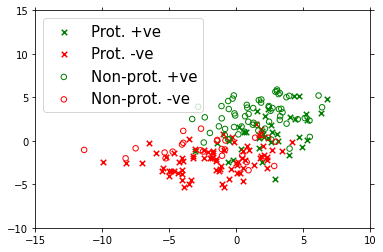

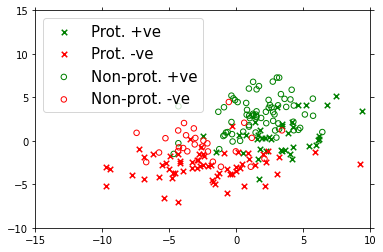

In [4]:
# Plotting training and test data
train_data, X_train, y_train = generate_synthetic_data(2000,True)
test_data, X_test, y_test= generate_synthetic_data(500,True)

## How to
Throughout this notebook we will be analyzing classifiers with different notions of fairness by computing the test error of the classifier(s), computing different fairness metrics, outputting the confusion matrix and plotting the classification boundary. Lets start with looking at the functions that perfom this:
-  H.1) Define a function `test_error` to compute the test error of a classifier. Use as input the ground truth (correct) labels `y_true` and labels as predicted by the classifier `y_pred`. 


In [5]:
def test_error(y_pred,y_true):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.numpy()
        y_true = y_true.numpy()
    return #TODO

We  now take a look at some common group fairness metrics: *demographic parity* and *equal opportunity*, which is a weaker version of *equalized odds*. Note, for simplicity, we assume throughout binary targets $Y$, $\widehat{Y}$ and protected attributes $A$. 

- *Statistical Parity* ([Dwork et al. (2011)](https://dl.acm.org/doi/pdf/10.1145/2090236.2090255)): A binary predictor $\hat{Y}$ satisfies equal opportunity with respect to $A$ and $Y$ if $$\operatorname{Pr}\{\widehat{Y}=1 \mid A=0\}=\operatorname{Pr}\{\widehat{Y}=1 \mid A=1\}.$$ 


- *Equalized Odds* ([Hardt et al. (2016)](https://arxiv.org/pdf/1610.02413.pdf)): A binary predictor $\widehat{Y}$ satisfies equalized odds with respect to protected attribute $A$ and outcome $Y$, if $\widehat{Y}$ and $A$ are independent conditional on $Y$. This can be expressed as:
$$ \begin{equation}
\operatorname{Pr}\{\widehat{Y}=1 \mid A=0, Y=y\}=\operatorname{Pr}\{\widehat{Y}=1 \mid A=1, Y=y\}, \quad y \in\{0,1\}
\end{equation}$$


- *Equal Opportunity* ([Hardt et al. (2016)](https://arxiv.org/pdf/1610.02413.pdf)): A binary predictor $\hat{Y}$ satisfies equal opportunity with respect to $A$ and $Y$ if $$\operatorname{Pr}\{\widehat{Y}=1 \mid A=0, Y=1\}=\operatorname{Pr}\{\widehat{Y}=1 \mid A=1, Y=1\}.$$ 

Lets now put this into code. Note, whenever we refer to *fairness metrics* in the following, we will refer to *statistical parity* and *equal opportunity*:
- H.2) Define a function `statistical_parity`, that helps to compute *statistical parity* in the binary case. The function should compute $\operatorname{Pr}\{\widehat{Y}=1 \mid A=a\}$, given predictions $\widehat{Y}$ for group $a$. 

In [6]:
def statistical_parity(y, mask):
    # mask allows to select members of one group
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
     #TODO  # conditioned elements
    return  #TODO

- H.3) Define a function `equal_opportunity`, that helps to compute *equal opportunity* in the binary case. The function should computes $\operatorname{Pr}\{\widehat{Y}=1 \mid A=a, Y=1\}$, given predictions $\widehat{Y}$, for a ground truth label $y$ and group $a$. 

In [7]:
def equal_opportunity(y_pred, y, mask):
    # mask allows to select members of one group
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
     #TODO # conditioned true positives
    return  #TODO

- H.4) Define a function called `confusion_matrix` that prints the confusion matrix given predicted labels `y_pred`, true lables `y_true` and optionally a mask that allows to select a subgroup of samples (e.g. only those with a protected sensitive attribute).

In [ ]:
def confusion_matrix(y_pred, y_true, mask=None):
    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    size = y_true.size(0) if mask is None else mask.sum().item()
    sum_and_int = lambda x: x.sum().long().item()
    to_percentage = lambda l: [f'{float(y)* 100. / size :.2f}%' for y in l]
    
    y_pred_binary = (y_pred > 0.5).float()
    if mask is None:
        mask = torch.ones_like(y_pred)
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    mask = mask.float()
    
    true_positives =  #TODO
    false_positives =  #TODO
    
    true_negatives =  #TODO
    false_negatives =  #TODO
    
    total_positives =  #TODO
    total_negatives =  #TODO
    total =  #TODO
    
    # Show the confusion matrix
    table = tt.Texttable()
    table.header(['Pred/Real', 'Positive', 'Negative', ''])
    table.add_row(['Positive'] + to_percentage([true_positives, false_positives, true_positives + false_positives]))
    table.add_row(['Negative'] + to_percentage([false_negatives, true_negatives, false_negatives + true_negatives]))
    table.add_row([''] + to_percentage([total_positives, total_negatives, total]))
    
    return table

- H.5) Define a function called `plot_svc_boundary` that helps to plot the decision boundary of an SVC classifier (like in the last tutorial) and a function called `get_lr_boundary` that helps to plot the decision boundary of a LR classifier in the 2D space (i.e. to draw the decision boundary in your data plot above).

In [ ]:
# return decision boundary for SVC
def get_svc_boundary(w,b,x1,x2):
    w1, w2 = w
    y1 = #TODO
    y2 = #TODO
    return [[x1,x2],[y1,y2]]

# return decision boundary for LR
def get_lr_boundary(coef, intercept, x1, x2):
      w1, w2 = coef
      y1 = #TODO
      y2 = #TODO
      return [[x1,x2],[y1,y2]]


- H.6) We define a function called `get_statistics` that plots the test error of a model, the confusion matrix for both groups combined as well as for each group separately and outputs both fairness metrics.

In [ ]:
tensor = lambda x: torch.tensor(x.to_numpy())
def get_statistics(model, X_test, y_test, pred, mask):
    print("Test error: ", test_error(pred,y_test))
    print(confusion_matrix(pred,y_test).draw())
    print(confusion_matrix(pred,y_test,mask).draw())
    print(confusion_matrix(pred,y_test,1-mask).draw())
    pred = torch.tensor(pred)
    y_test = torch.tensor(y_test)
    print("statistical_parity for 1: %.3f, for 0: %.3f, total: %.3f" % (statistical_parity(pred,mask),statistical_parity(pred,1-mask), statistical_parity(pred,mask)-statistical_parity(pred,1-mask)))
    print("equal_opportunity for 1: %.3f, for 0: %.3f, total: %.3f" % (equal_opportunity(pred, y_test,mask),equal_opportunity(pred, y_test,1-mask), equal_opportunity(pred, y_test,mask) - equal_opportunity(pred, y_test,1-mask)))

# 1. Plain classifier
We start with looking how a standard SVM and LR sepearte the given biased dataset.
- Train both a Support Vector Classifier (SVC) and a linear regression (LR) classifier on the full dataset. You can use a standard implementation from [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), respectively. Evaluate test error, fairness metrics and the confusion matrix for i) all samples, ii) only samples of unprotected group and iii) only samples of protected group. Plot the decision boundary. What do you observe?

In [ ]:
# select plain dataset trainig and test
_X_train = train_data[["x1","x2","sensitive"]].to_numpy()
_y_train = train_data["y"].to_numpy()
_X_test = test_data[["x1","x2","sensitive"]].to_numpy()
_y_test = test_data["y"].to_numpy()
s_test = test_data["sensitive"].to_numpy()

In [ ]:
# define and fit SVC
svc = SVC(kernel='linear',C=1000)
svc.fit(_X_train,_y_train)

# get predictions from SVC
y_pred = svc.predict(_X_test)

# get statistics from predictions
get_statistics(svc, _X_test, (y_test+1)/2 , (y_pred+1)/2 ,s_test)

In [ ]:
# Plot data and decision boundary
fig,ax = plt.subplots(1,1)
ax.plot(*get_svc_boundary(svc.coef_[0][0:2], svc.intercept_, -15,10), color="black", label= "A")
plot_data(X_test[:,0:2],y_test,s_test,axes=ax)

In [ ]:
# define and train Logistic Regression classifier
#TODO

# get predictions 
#TODO

# get statistics
#TODO

In [ ]:
# plot data and decision boundary
fig,ax = plt.subplots(1,1)
ax.plot(*get_lr_boundary(lr.coef_[0][0:2], lr.intercept_, -15,10), color="black", label= "A")
plot_data(X_test[:,0:2],y_test,s_test,axes=ax)

# 2. Unaware classifier
Can't we just train a fair classifier by removing the sensitive attribute from our dataset? 
- Modify the dataset such that contains only non-sensitive features. Train both the SVM and LR classifier on it.  Evaluate test error, fairness metrics and the confusion matrix for i) all samples, ii) only samples of unprotected group and iii) only samples of protected group. Plot the decision boundary. What do you observe? 

In [ ]:
# select plain dataset trainig and test
#TODO

In [ ]:
# define and fit SVC
#TODO

# get predictions from SVC
#TODO

# get statistics from predictions
#TODO

In [ ]:
# Plot data and decision boundary
#TODO

In [ ]:
# define and train Logistic Regression classifier
#TODO

# get predictions 
#TODO

# get statistics
#TODO

In [ ]:
# plot
#TODO

# Mechanisms to achive group fairness
In the lecture, we learned that there are three main approaches to achieveing group fairness: 
- pre-preprocessing, which modifies the input data to remove (potential) bias
- post-processing, which modifies the decisions of a (potentially) unfair classifier
- in-processing, which modifies training to directly learn a fair classifier

<!-- ![alt text](methods.png "Methods to achieve group fairness") -->

Lets now take a closer look at one way of altering the training of a classification algorithm to achieve higher levels of fairness (in-processing).

# 3. In-processing

Let's now take a more detailed look at in-processing approaches for logistic regression e.g. [Zafar et al. (2017)](https://arxiv.org/pdf/1507.05259.pdf). We provide you with the training framework. 

## Training Framework
This is the pytorch training framework for a Logistic Regression (LR) classifier we provide you. In order to modify the optimization of the LR classifier we make all function explicit. 

In [ ]:
import torch.nn as nn
class LogisticRegression(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(size, 1))
        self.bias = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.theta)+self.bias).flatten()
    
    def predict(self, x):
        return self.forward(x) >= 0.5
    
@torch.no_grad()  # This is to let Pytorch modify our parameters
def gradient_descent(model, learning_rate):
    model.theta -= learning_rate * model.theta.grad
    model.bias -= learning_rate * model.bias.grad

def train(model, loss_function, x, y, epochs, learning_rate, print_freq=100, verbose=True, **kwargs):
    for i in range(epochs):
        model.zero_grad()  # sets all the gradients back to 0
    
        y_pred = model(x)
        loss = loss_function(y_pred, y, **kwargs)
        if (i == 0 or (i+1) % print_freq == 0)  and verbose:
            print(f'Epoch {i+1}: loss {loss.item()}')
            
        loss.backward()  # calculates the gradient of all the parameters
        gradient_descent(model, learning_rate)

In [ ]:
# get training and test datasets as pytorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = (torch.tensor(y_train).float()+1)/2
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = (torch.tensor(y_test).float()+1)/2
s_train=X_train_tensor[:,2]
s_test = test_data["sensitive"].to_numpy()

## Plain Classifier
- 5.1) Lets begin with training a plain LR classifier using the framework. Use binary cross entropy as loss function, which you hand to the training function. Evaluate test error, fairness metrics and the confusion matrix for i) all samples, ii) only samples of unprotected group and iii) only samples of protected group. Plot the decision boundary.

In [ ]:
# define the model
my_model_me = LogisticRegression(X_train_tensor.size(1))
# define the loss function
my_loss_function = nn.functional.binary_cross_entropy  # cross entropy loss
# train the model
train(my_model_me, my_loss_function, X_train_tensor, y_train_tensor, epochs=1000, learning_rate=0.05)

In [ ]:
# get model predictions
y_pred_me =  my_model_me.predict(X_test_tensor)
# get statistics
get_statistics(my_model_me, X_test_tensor, y_test_tensor, y_pred_me, s_test)

In [ ]:
# plot decision boundary
fig,ax = plt.subplots(1,1)
ax.plot(*get_lr_boundary(my_model_me.theta.detach().numpy()[0:2], my_model_me.bias.detach().numpy()[0], -15,10), color="black", label= "A")
plot_data(X_test[:,0:2],y_test,X_test[:,2],axes=ax)

## Fair Classifier - Statistical Parity
- 5.2) Train the LR classifier with the fairness metric `statistical_parity`.  This is a constrained optimization problem and you can use an lagrange approach , i.e. `bce_loss + lambda * (unfairness)^2`. Alter the loss function in a suitable way. Then train and evaluate. You can use $\lambda = 100$. What do you observe?

In all cases: 

In [ ]:
# define statistical parity loss
def sp_loss(y_pred, y, X_sens, lambda_ = 100.0):
    
    bce_loss = nn.functional.binary_cross_entropy(y_pred, y)
    
    #TODO
    
    return #TODO

In [ ]:
# define model
my_model_sp = LogisticRegression(X_train_tensor.size(1))

# define loss function 
my_loss_function = sp_loss

# train model
train(my_model_sp, my_loss_function, X_train_tensor, y_train_tensor, X_sens=s_train, epochs=2000, learning_rate=0.05)

In [ ]:
# get predictions
y_pred_sp  = my_model_sp.predict(X_test_tensor)
# get statistivs
get_statistics(my_model_sp, X_test_tensor, y_test_tensor,y_pred_sp ,s_test)

In [ ]:
# plot
fig,ax = plt.subplots(1,1)
ax.plot(*get_lr_boundary(my_model_sp.theta.detach().numpy()[0:2], my_model_sp.bias.detach().numpy()[0], -15,10), color="black", label= "A")
plot_data(X_test[:,0:2],y_test,X_test[:,2],axes=ax)

## Fair Classifier - Equal Opportunity
- 5.3)  Train the LR classifier with the fairness metric `equal_opportunity`. This is a constrained optimization problem and you can use an lagrange approach , i.e. `bce_loss + lambda * unfairness`. Alter the loss function in a suitable way. Then train and evaluate. You can use $\lambda = 100$. What do you observe?

In [ ]:
# define equal opportunity loss
def eo_loss(y_pred, y, X_sens, lambda_ = 100):
    bce_loss = nn.functional.binary_cross_entropy(y_pred, y)
    
    #TODO
    
    return # TODO

In [ ]:
# define model
# TODO

# define loss function
# TODO

# train model
# TODO

In [ ]:
# get prediction
# TODO

# get statistics
# TODO

In [ ]:
# plot
# TODO

# 4. Fairness-Accuracy Tradeoff

As introduced in the lecture, the *fairness-accuracy-tradeoff* describes that in general, higher fairness yields lower accuracy, because a fairness constraint diverts the objective from accuracy alone to both accuracy and fairness. Let's try to see that with our implementation. While optimizing for accuracy subject to fairness constraints in the Lagrange implementation above, we adjust the weight that the fairness objective has during training with $\lambda$. While optimizing for accuracy subject to fairness constraints, the higher we choose $\lambda$ the more weight the fairness constraint has in the optimization. For a very high $\lambda$ this may result in a perfectly fair classifier but similarily a rather big loss in accuracy. Lets see if we try a range of values of $\lambda$, what kind of accuracy we achieve. 
- 6.1) For $\lambda = [0.01, 0.1, 0, 1, 10, 100, 1000]$ train a fair LR classifier with the fairness constraint `statistical_parity`. Use the function `get_accuracy_fairness` to evaluate accuracy and fairness metrics for the different values of $\lambda$. What do you observe?

In [9]:
from functools import partial
def get_accuracy_fairness(model, X_test, y_test, pred, mask):
    err = # TODO
    print("Test error: ", err)
    y_test = torch.tensor(y_test)
    sp_1,sp_0 = # TODO
    eo_1,eo_0 = # TODO
    print("statistical_parity for 1: %.3f, statistical_parity for 0: %.3f" % (sp_1, sp_0))
    print("equal_opportunity for 1: %.3f, equal_opportunity for 0: %.3f" % (eo_1,eo_0))
    return err, sp_1, sp_0, eo_1, eo_0

In [ ]:
lambdas = [0,0.01,0.1,1,10,100,1000,10000]
err_list, sp_1_list, sp_0_list, eo_1_list, eo_0_list = [],[],[],[],[] 
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = (torch.tensor(y_train).float()+1)/2
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = (torch.tensor(y_test).float()+1)/2
    
for lambda_ in lambdas:

    # define model
    # TODO
    
    # define loss function - HINT: you can use partial
    # TODO
    
    # train model 
    # TODO 
    
    # get predictions
    # TODO
    
    err, sp_1, sp_0, eo_1, eo_0 = get_accuracy_fairness(my_model_sp, X_test_tensor, y_test_tensor, y_pred ,s_test)
    err_list.append(err)
    sp_1_list.append(sp_1)
    sp_0_list.append(sp_0)
    eo_1_list.append(eo_1)
    eo_0_list.append(eo_0)
    print()

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(15,15))
axes[0].plot(err_list)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels(lambdas)
axes[0].set_ylabel("Error")
axes[0].set_xlabel("Lambda")

axes[1].plot(sp_1_list, label="1")
axes[1].plot(sp_0_list, label="0")
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels(lambdas)
axes[1].set_ylabel("Statistical Parity")
axes[1].set_xlabel("Lambda")
axes[1].legend()

axes[2].plot(eo_1_list, label="1")
axes[2].plot(eo_0_list, label="0")
axes[2].set_xticks(range(len(lambdas)))
axes[2].set_xticklabels(lambdas)
axes[2].set_ylabel("Equal Opportunity")
axes[2].set_xlabel("Lambda")
axes[2].legend()

- 6.2) For $\lambda = [0.01, 0.1, 0, 1, 10, 100, 1000]$ train a fair LR classifier with the fairness constraint `equal_opportunity`. Use the provided function `plot_accuracy_fairness` to evaluate accuracy and fairness metrics for the different values of $\lambda$. What do you observe? 

In [ ]:
# TODO - simimilar to above but with equal_opportunity

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(15,15))
axes[0].plot(err_list)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels(lambdas)
axes[0].set_ylabel("Error")
axes[0].set_xlabel("Lambda")

axes[1].plot(sp_1_list, label="1")
axes[1].plot(sp_0_list, label="0")
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels(lambdas)
axes[1].set_ylabel("Statistical Parity")
axes[1].set_xlabel("Lambda")
axes[1].legend()

axes[2].plot(eo_1_list, label="1")
axes[2].plot(eo_0_list, label="0")
axes[2].set_xticks(range(len(lambdas)))
axes[2].set_xticklabels(lambdas)
axes[2].set_ylabel("Equal Opportunity")
axes[2].set_xlabel("Lambda")
axes[2].legend()

# 5. Real-world data
So far we have been using synthetic data as it allowed us to plot data and decision boundaries to get an intuition of what classification under different fairness notions can look like. Fairness plays an important role the moment we use an algorithm in the real world. Therefore, lets take a look at real world data. 


## Compas Data
In 2016 ProPublica, an independent, nonprofit organization of investigative journalists, reported that an algorithm, which was used in the US legal system to predict a criminal defendant’s likelihood to re-offend, was racially biased. The algorithm referred to as COMPAS, which stands for Correctional Offender Management Profiling for Alternative Sanctions, is offered by the vendor Northpointe, Inc. ProPublica showed that black defendants were far more likely than white defendants to be incorrectly predicted to be at a higher risk of recidivism, while white defendants were more likely than black defendants to be incorrectly predicted to be at low risk (see [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), [methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) of analysis). 

The authors published the so-called [COMPAS Dataset](https://github.com/propublica/compas-analysis/).  This dataset is known in the fairness research community as the and a widely used to test the fairness of algorithms. We chose the dataset because of its extensive analysis available. The dataset contains the the criminal history, jail and prison time, demographics and COMPAS risk scores for defendants from Broward County, Florida, from 2013 and 2014. The dataset originally contains 7214. We load the dataset via the python class `load_compas_data.py` that we have also uploaded. It also carries out pre-processing for us. This reduces the dataset to 5278 samples with the following variables: 

- All features $X$: age `age_cat`, race`race`, sex `sex`, number of prior convictions `priors_count`, severity of charge `c_charge_degree`
- Sensitive feature $S$: race `race` 
- Target label $y$: accused of a crime within two years `two_year_recid` (`1`, if yes, `0` otherwise)








In [ ]:
from load_compas_data import load_compas_data
x, y, x_sens = load_compas_data()
print(f'Number of samples {x.shape[0]}, number of features {x.shape[1]}')

In [ ]:
X = np.concatenate((x,x_sens["race"].reshape(-1,1)),axis=1)
y = (y+1)/2

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

train_size = int(X.size(0) * 0.8)
random_perm = torch.randperm(X.size(0))
train_idx, test_idx = random_perm[:train_size], random_perm[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

- 7.1) Take a look at the analysis of the dataset [here](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). What do you take away from this analysis? 

- 7.2) Follow the same steps as in (5. In-Processing): Train the plain, DP-fair, EO-fair classifier and evaluate their performance on the Compas dataset. What do you observe?

In [ ]:
#For all three models:
## define model
## TODO

## define loss function
## TODO

## train model
## TODO

## get prediction
## TODO

## get statistics
## TODO


# 6. Further Reading
Ethical machine learning, especially fairness in machine learning, has enjoyed increasing attention in the last years. Here is a non-exhaustive list of links for exploration, if you are interested in more information: 
- Less-technical: Orwat (2019): Risks of Discrimination through the Use of Algorithms, published by the German Federal Anti-Discrimination Agency. Available in [German](https://www.antidiskriminierungsstelle.de/SharedDocs/Downloads/DE/publikationen/Expertisen/studie_diskriminierungsrisiken_durch_verwendung_von_algorithmen.pdf?__blob=publicationFile&v=6) and [English](https://www.antidiskriminierungsstelle.de/SharedDocs/Downloads/EN/publikationen/Studie_en_Diskriminierungsrisiken_durch_Verwendung_von_Algorithmen.pdf?__blob=publicationFile&v=4).
- Technical: Barocas et al. (2019): Fairness and Machine Learning, [here](https://fairmlbook.org/) - a comprehensive technical overview of basic fairness approaches and concepts. Contains also links to further tutorials and lecture material.
- Advanced: Publications at ACM FAccT Conference [here](https://facctconference.org/) - recent cross-disciplinary scientific advances in the research community concerned with fairness, accountability, and transparency in socio-technical systems.
